In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import tensorflow as tf
import random
import progressbar
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, MaxPool2D, LeakyReLU

In [2]:
joint_name = ['HeadF', 'HeadB', 'HeadL', 'SpineF', 'SpineM', 'SpineL', 
            'Offset1', 'Offset2', 'HipL', 'HipR', 'ElbowL', 'ArmL', 
            'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 
            'KneeL', 'ShinL', 'ShinR']

joints_idx = [[1, 2], [2, 3], [1, 3], [2, 4], [1, 4], [3, 4], [4, 5], 
            [5, 6], [4, 7], [7, 8], [5, 8], [5, 7], [6, 8], [6, 9], 
            [6, 10], [11, 12], [4, 13], [4, 14], [11, 13], [12, 13], 
            [14, 15], [14, 16], [15, 16], [9, 18], [10, 17], [18, 19], 
            [17, 20]]

In [3]:
# normalizes a matrix
def normalize(matrix):
    max_numb = max(matrix[~np.isnan(matrix)])
    norm = matrix/max_numb
    return np.array(norm)
    # return matrix

In [4]:
from scipy.spatial.distance import cdist
# Get the distance to every single point 
def getAllDistances(matFile, numb):
    mat = matFile[numb]
    mat = mat.T
    dist = cdist(mat, mat, 'euclidean')
    return normalize(dist)

In [5]:
# Get the absolute height difference to every single point 
def getAllHeights(matFile, numb):
    mat = matFile[numb]
    z = mat[2]
    reshaped = int(matFile.shape[2])
    height = []

    for i in range(reshaped):
        for j in range(reshaped):
            if np.nan in [z[i], z[j]]:
                height.append(np.nan)
            else:
                height.append(np.abs(z[i]-z[j]))

    # normalizes height data
    height = normalize(np.array(height).reshape(reshaped, reshaped))
    return height


In [6]:
# Get the angle to every single point 
def getAllAngles(matFile, numb):
    mat = matFile[numb]
    mat = mat.T
    angle = cdist(mat, mat, 'cosine')
    return normalize(angle)

In [7]:
def addNans(raw):
    raw_copy = np.array(raw.copy())

    for i in range(raw_copy.shape[0]):
        rand_numb = np.random.randint(0, 4)
        rand_index = random.sample(range(3, 20), rand_numb)
        for j in range(rand_numb):
            raw_copy[i][:,rand_index[j]] = np.nan
    return raw_copy


In [8]:
def getData(data, numb): 
    cnn_inputs = []
    bar = progressbar.ProgressBar()

    for i in bar(range(numb)):
        dist = getAllDistances(data, i) 
        height = getAllHeights(data, i)
        angle = getAllAngles(data, i)
        for j in range(0, data.shape[2]):
            temp = np.array([dist[j], height[j], angle[j]])
            first = temp[:,0:3]
            second = temp[:,3:20]
            first = first [ :, first[0].argsort()]
            second = second [ :, second[0].argsort()]
            output = np.concatenate((first, second), axis =1)
            cnn_inputs.append(output)

    # DIMENTION CHANGE
    cnn_inputs = np.array(cnn_inputs)[:,:,:13]
    # cnn_inputs = np.array(cnn_inputs)[:,:,:20]
    cnn_inputs = np.array(cnn_inputs).reshape((cnn_inputs.shape[0], 39))
    # cnn_inputs = np.array(cnn_inputs).reshape((numb*data.shape[2], 60))
    where_are_NaNs = np.isnan(cnn_inputs)
    cnn_inputs[where_are_NaNs] = 0
    return cnn_inputs


In [9]:
train_file = loadmat('mat_files/bigSet1.mat')
test_file = loadmat('mat_files/bigSet2.mat')

In [10]:
train_data = train_file['bigSet1']
test_data = test_file['bigSet2']
train_labels = train_file['labels1']
test_labels = test_file['labels2']
# set numb of data used
numb_train = len(train_data)
numb_test = 1000

# Take some frames from the list to use as trian and test data
index_train = np.linspace(0, len(train_labels), num = numb_train, endpoint=False).astype(int)
index_test = np.linspace(0, len(test_labels), num = numb_test, endpoint=False).astype(int)
# pre_train_data = train_data[index_train]
# pre_train_labels = train_labels[index_train]
pre_train_data = train_data
pre_train_labels = train_labels
pre_test_data = test_data[index_test]
pre_test_labels = test_labels[index_test]

print("Shape of pre_train_data:", pre_train_data.shape)
print("Shape of pre_test_data:", pre_test_data.shape)
print("Shape of pre_train_labels:", pre_train_labels.shape)
print("Shape of pre_test_labels:", pre_test_labels.shape)


Shape of pre_train_data: (221147, 3, 20)
Shape of pre_test_data: (1000, 3, 20)
Shape of pre_train_labels: (221147, 20)
Shape of pre_test_labels: (1000, 20)


In [11]:
# Get measurement data for every 3D point
train_data = getData(pre_train_data, numb_train)
test_data = getData(pre_test_data, numb_test)

# Flatten the trian labels to fit dimentions of data
train_labels = pre_train_labels.flatten()[0:(numb_train*20)]-1
test_labels = pre_test_labels.flatten()[0:(numb_test*20)]-1

print("Shape of train_data:", train_data.shape)
print("Shape of test_data:", test_data.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of test_labels:", test_labels.shape)

100% (221147 of 221147) |################| Elapsed Time: 0:11:09 Time:  0:11:09
100% (1000 of 1000) |####################| Elapsed Time: 0:00:11 Time:  0:00:11


Shape of train_data: (4422940, 39)
Shape of test_data: (20000, 39)
Shape of train_labels: (4422940,)
Shape of test_labels: (20000,)


In [12]:
# Get index where the data is all 0
nans_train = np.sort(np.where(~train_data.any(axis=1))[0])[::-1]
nans_test = np.sort(np.where(~test_data.any(axis=1))[0])[::-1]

# Turn data into lists
train_data_new = list(train_data)
test_data_new = list(test_data)
train_labels_new = list(train_labels)
test_labels_new = list(test_labels)

bar = progressbar.ProgressBar()
# Remove the nan values 
for i in bar(nans_train):
    train_data_new.pop(i)
    train_labels_new.pop(i)
bar = progressbar.ProgressBar()
for i in bar(nans_test):
    test_data_new.pop(i)
    test_labels_new.pop(i)

# Turn data back into array
train_data_new = np.array(train_data_new)
train_labels_new = np.array(train_labels_new)
test_data_new = np.array(test_data_new)
test_labels_new = np.array(test_labels_new)

print("Shape of train_data_new:", train_data_new.shape)
print("Shape of test_data_new:", test_data_new.shape)
print("Shape of train_labels_new:", train_labels_new.shape)
print("Shape of test_labels_new:", test_labels_new.shape)

100% (397563 of 397563) |################| Elapsed Time: 0:49:07 Time:  0:49:07
100% (1741 of 1741) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


Shape of train_data_new: (4025377, 39)
Shape of test_data_new: (18259, 39)
Shape of train_labels_new: (4025377,)
Shape of test_labels_new: (18259,)


In [13]:
# Creates the ML training platform to predict rat joints
def ml_traning(train_data, train_labels, test_data, test_labels):
    # DIMENTION CHANGE
    train_data = train_data.reshape(train_data.shape[0], 39)
    test_data = test_data.reshape(test_data.shape[0], 39)
    # train_data = train_data.reshape(train_data.shape[0], 60)
    # test_data = test_data.reshape(test_data.shape[0], 60)
    train_data = train_data.astype('float32')
    test_data = test_data.astype('float32')

    model = createModel()
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(x=train_data,y=train_labels, verbose='auto', batch_size=20, epochs=2)
    
    output = model.evaluate(test_data, test_labels)
    print("Loss:", output[0])
    print("Accuracy:", output[1]*100)
    return model

# Creates the model for the CNN
def createModel():
    model = Sequential()
    model.add(Dense(120, activation= LeakyReLU()))
    model.add(Dense(320, activation= LeakyReLU()))
    # model.add(Dropout(rate=0.25))
    model.add(Dense(80, activation= LeakyReLU()))
    # model.add(Dense(13, activation = "softmax"))
    model.add(Dense(len(joint_name), activation = "softmax"))
    return model

In [14]:
skeleton_model = ml_traning(train_data_new, train_labels_new, test_data_new, test_labels_new)

Epoch 1/2
201269/201269 [==============================] - 443s 2ms/step - loss: 0.5543 - accuracy: 0.8184
Epoch 2/2
571/571 [==============================] - 2s 1ms/step - loss: 0.6811 - accuracy: 0.8109
Loss: 0.6811474561691284
Accuracy: 81.08877539634705


In [15]:
# Tests individual points and tells you if the CNN worked
def handTest(image_index, test_data, label, model, maxNumb):
    max_index = len(joint_name)*maxNumb-1
    if image_index <= max_index:
        predict(test_data, image_index, label, model)
    else:
        print("ERROR: Your predict_index must be below", max_index)

# Showing individual predictions
def predict(data, image_index, label, model):
    img = [data[image_index]]
    # DIMENTION CHANGE
    img = np.array(img).reshape(3,13)
    # img = np.array(img).reshape(3,20)
    plt.imshow(img)
    plt.show()

    pred = model.predict(img.reshape(1, 39))
    # pred = model.predict(img.reshape(1, 60))
    predict = pred.argmax()
    actual = label[image_index]

    print("Actual:", actual)
    print("Predicted:", predict)
    
    if predict == actual:
        print("YAY ✿(ᵔ‿ᵔ)")
    else:
        print("Wrong (◕︵◕)")

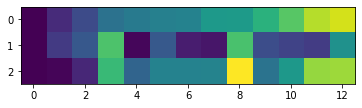

Actual: 0
Predicted: 0
YAY ✿(ᵔ‿ᵔ)


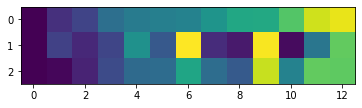

Actual: 1
Predicted: 1
YAY ✿(ᵔ‿ᵔ)


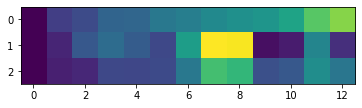

Actual: 2
Predicted: 2
YAY ✿(ᵔ‿ᵔ)


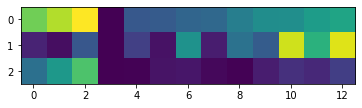

Actual: 7
Predicted: 7
YAY ✿(ᵔ‿ᵔ)


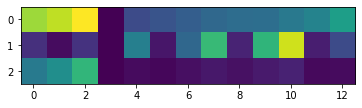

Actual: 5
Predicted: 5
YAY ✿(ᵔ‿ᵔ)


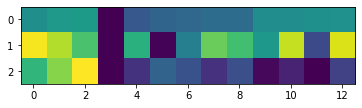

Actual: 10
Predicted: 10
YAY ✿(ᵔ‿ᵔ)


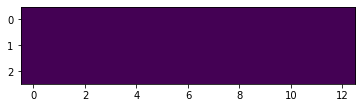

Actual: 11
Predicted: 10
Wrong (◕︵◕)


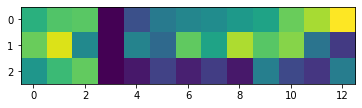

Actual: 13
Predicted: 13
YAY ✿(ᵔ‿ᵔ)


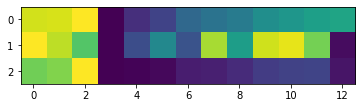

Actual: 19
Predicted: 19
YAY ✿(ᵔ‿ᵔ)


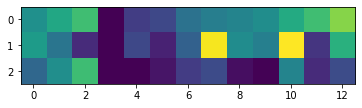

Actual: 12
Predicted: 12
YAY ✿(ᵔ‿ᵔ)


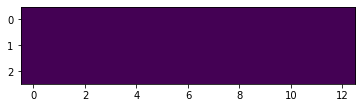

Actual: 14
Predicted: 10
Wrong (◕︵◕)


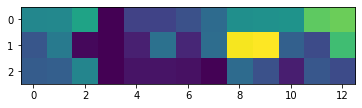

Actual: 3
Predicted: 3
YAY ✿(ᵔ‿ᵔ)


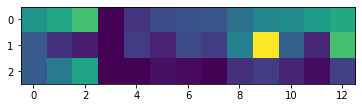

Actual: 6
Predicted: 6
YAY ✿(ᵔ‿ᵔ)


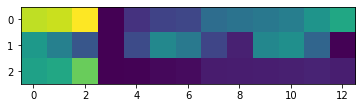

Actual: 9
Predicted: 9
YAY ✿(ᵔ‿ᵔ)


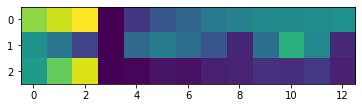

Actual: 17
Predicted: 17
YAY ✿(ᵔ‿ᵔ)


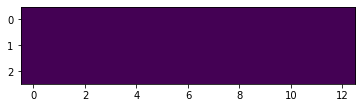

Actual: 8
Predicted: 10
Wrong (◕︵◕)


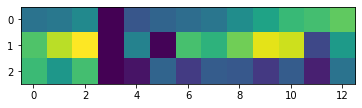

Actual: 15
Predicted: 11
Wrong (◕︵◕)


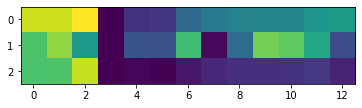

Actual: 16
Predicted: 16
YAY ✿(ᵔ‿ᵔ)


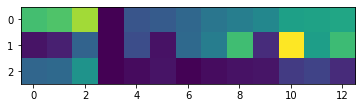

Actual: 4
Predicted: 4
YAY ✿(ᵔ‿ᵔ)


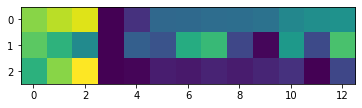

Actual: 18
Predicted: 18
YAY ✿(ᵔ‿ᵔ)


In [16]:
for i in range(420,440):
    handTest(i, test_data, test_labels, skeleton_model, numb_test)

Train input


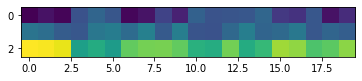

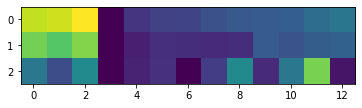

Test input


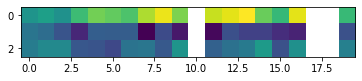

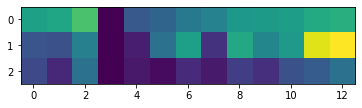

In [17]:
index = 1234
frame = int(index/20)

print("Train input")
plt.imshow(pre_train_data[frame].reshape(3,20))
plt.show()
# DIMENTION CHANGE
plt.imshow(train_data[index].reshape(3,13))
# plt.imshow(train_data[index].reshape(3,20))
plt.show()

print("Test input")
plt.imshow(pre_test_data[frame].reshape(3,20))
plt.show()
plt.imshow(test_data[index].reshape(3,13))
# plt.imshow(test_data[index].reshape(3,20))
plt.show()

In [18]:
temporal = loadmat('mat_files/test_temp.mat')

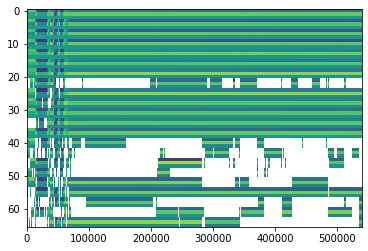

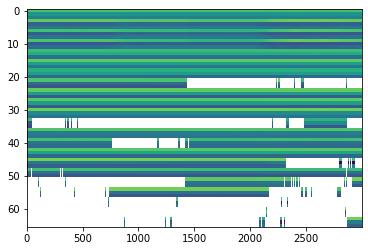

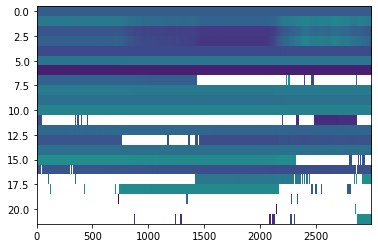

In [31]:
time_pts = temporal['new_combed']
num_fms = 3000
num_pts = int(time_pts.shape[0]/3) #22
test_pts = time_pts[:,:num_fms]

plt.imshow(time_pts, interpolation='nearest', aspect="auto")
plt.show()
plt.imshow(test_pts, interpolation='nearest', aspect="auto")
plt.show()
plt.imshow(test_pts[::3], interpolation='nearest', aspect="auto")
plt.show()

In [20]:
input_pts = test_pts.reshape(num_pts, 3, num_fms).T

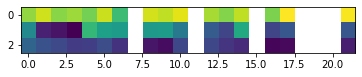

In [33]:
plt.imshow(input_pts[2999])

In [21]:
processed_time = getData(input_pts, len(input_pts))

process_pts = processed_time.reshape(num_fms, 22, 39)

100% (3000 of 3000) |####################| Elapsed Time: 0:00:05 Time:  0:00:05


In [ ]:
processed = np.transpose(processed_time.reshape(num_fms, 22, 39),(1, 0, 2))

In [22]:
chunks = []
temp = np.ones((22,num_fms))
bar = progressbar.ProgressBar()
# run through all the registered points (0,22)
for i in bar(range(num_pts)):
    # get every third row
    row = i*3
    row_list = []
    temp_list = []

    # run through length of each row (0,3000)
    for j in range(num_fms): 
        # not a nan, add index to list
        if not np.isnan(test_pts[row][j]):
            temp_list.append(j)
            temp[i][j] = temp[i][j]*2
        # if element is a nan and the current list is not empty
        elif len(temp_list) > 0:
            # add list to output and clear the list
            row_list.append([temp_list[0], temp_list[-1]])
            temp_list = []
    # edge case, add to output if the list still contains values
    if len(temp_list) > 0:
        row_list.append([temp_list[0], temp_list[-1]])
    chunks.append(row_list)

100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


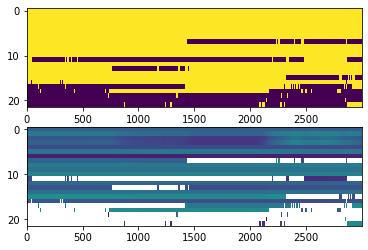

In [23]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.imshow(temp, interpolation='nearest', aspect="auto")
ax2.imshow(test_pts[::3], interpolation='nearest', aspect="auto")

In [24]:
# Check the chunk list
chunks = np.array(chunks, dtype=list)
# (0,21)
for i in range(len(chunks)):
    print("Point: "+str(i) +", Chunks: " + str(len(chunks[i])))
    # # length of chunk
    # for j in range(len(chunks[i])):
    #     begin = chunks[i][j][0]
    #     end = chunks[i][j][-1]
    #     print("        " + str(end-begin+1)+ " ["+ str(begin)+ ", " + str(end) + "]")

Point: 0, Chunks: 1
Point: 1, Chunks: 1
Point: 2, Chunks: 1
Point: 3, Chunks: 1
Point: 4, Chunks: 1
Point: 5, Chunks: 1
Point: 6, Chunks: 1
Point: 7, Chunks: 11
Point: 8, Chunks: 1
Point: 9, Chunks: 1
Point: 10, Chunks: 1
Point: 11, Chunks: 12
Point: 12, Chunks: 1
Point: 13, Chunks: 7
Point: 14, Chunks: 1
Point: 15, Chunks: 27
Point: 16, Chunks: 9
Point: 17, Chunks: 34
Point: 18, Chunks: 26
Point: 19, Chunks: 18
Point: 20, Chunks: 12
Point: 21, Chunks: 24


In [26]:
from scipy import stats
temporal_data = []
# segment_range = []
confidence_levels = []

# loop through all the points (0,22)
for i in range(len(chunks)):
# for i in range(3):
    seg_range = []
    mode_predict = []
    conf_predict = []
    conf_level = []

    # list of chunks in a row
    data = chunks[i]
    print("\nPoint: "+ str(i) + ", Segments: " + str(len(data)))
    
    # loop through all the chunks per row (0,1)
    for j in range(len(data)):
        conf = []
        pred = []
        seg = data[j] #segment range ie. [0,2999]
        lower = seg[0]
        upper = seg[1]+1
        seg_len = upper - lower
        
        # loop through range of each chunk (0,3000)
        for k in range(lower, upper): 
            # process_pts[frame num][point num] 
            model_pred = skeleton_model.predict(processed[i][k].reshape(1,39))

            # get the confidence of predicition
            if len(conf) == 0: 
                conf = model_pred[0]
            else:
                conf += model_pred[0]

            # get prediction
            pred.append(model_pred.argmax())
            
        # turn into arrays
        conf = np.array(conf)
        pred = np.array(pred)

        # get mode predictions
        mode_data = stats.mode(pred, axis = 0)
        mode_pred = mode_data[0].flatten()[0]
        mode_count = mode_data[1].flatten()[0]
        mode_conf = mode_count/seg_len

        # get confidence predictions
        conf_pred = conf.argmax()
        conf_count = np.sum(pred == conf_pred)
        conf_conf = conf.max()/seg_len

        # adding to output arrays
        # seg_range.append(seg)
        conf_level.append(conf)
        mode_predict.append([mode_pred, mode_conf, seg, (seg_len-mode_count), mode_count, seg_len])
        conf_predict.append([conf_pred, conf_conf, seg, (seg_len-conf_count), conf_count, seg_len])

        # Display current state
        print("Segment: "+str(j) + ")", seg, "Predicted point: (M:" + str(mode_pred) + ", C:" + str(conf_pred) + "), [" + str(mode_count) + ", " + str(conf_count) + "] /", seg_len, end = " ")
        if (mode_pred == conf_pred):
            print("Yay")
        else:
            print("Conflict")
    
    # adding to output arrays
    confidence_levels.append(conf_level)
    # segment_range.append(sorted(seg_range))
    temporal_data.append([mode_predict, conf_predict])


Point: 0, Segments: 1
Segment: 0) [0, 2999] Predicted point: (M:11, C:11), [2856, 2856] / 3000 Yay

Point: 1, Segments: 1
Segment: 0) [0, 2999] Predicted point: (M:2, C:0), [1477, 1320] / 3000 Conflict

Point: 2, Segments: 1
Segment: 0) [0, 2999] Predicted point: (M:0, C:0), [1269, 1269] / 3000 Yay

Point: 3, Segments: 1


KeyboardInterrupt: 

In [ ]:
for i in range(len(temporal_data[7][1])): 
    print(chunks[7][i])
    print(temporal_data[7][0][i], "\n")

In [ ]:
temp_new = np.ones((22,num_fms))
for i in range(len(temporal_data)):
    for j in range(len(temporal_data[i])):
        for k in range(len(temporal_data[i][j])):
            start = temporal_data[i][j][k][2][0]
            end = temporal_data[i][j][k][2][1] + 1
            for k in range(start, end):
                temp_new[i][k] +=1
fig, (ax1, ax2) = plt.subplots(2)
ax1.imshow(temp_new, interpolation='nearest', aspect="auto")
ax2.imshow(test_pts[::3], interpolation='nearest', aspect="auto")

In [ ]:
temp_copy = temporal_data.copy()
temp_data = np.array(temp_copy, dtype=object)
chunk_data = []
pred_data = temp_data[:,1] # 1 for confidence
# pred_data = temp_data[:,0] # 0 for mode
print(pred_data.shape)

for i in range(20):
    chunk_data.append([])

# putting the preditions into buckets
for i in range(20):
    index = pred_data[i]
    for j in range(len(index)):
        chunk_data[index[j][0]].append([i]+index[j])

for i in range(len(chunk_data)):
    print(i, len(chunk_data[i]))

In [ ]:
processed_pts = []

# squish all the data points
for i in range(20): 
    numb_index = []
    bounds = None
    current = chunk_data[i]
    sorted_current = sorted(current,key=lambda x: x[4])

    for j in reversed(range(len(sorted_current))):
        input_index = sorted_current[j]
        current_bounds = np.arange(input_index[3][0], input_index[3][1]+1).tolist()

        if len(numb_index) == 0:
            numb_index.append(input_index)
            bounds = current_bounds
        else:
            same = list(set(current_bounds) & set(bounds)) # gets overlapping elements 
            # no overlapp between the two lists
            if len(same) == 0:
                numb_index.append(input_index)
                bounds += current_bounds
            else: #if there is overlap between the two lists
                if current_bounds[0] in bounds and current_bounds[-1] in bounds:
                    # print(str(i) + ") Can't add index in range [" + str(current_bounds[0]) + ", " + str(current_bounds[-1]) + "] to [" + str(bounds[0])+ ", " + str(bounds[-1]) + "]")
                    pass
                elif current_bounds[0] in bounds:
                    print("Lower bound inside current bounds")
                    pass
                elif current_bounds[-1] in bounds:
                    print("Upper bound inside current bounds")
                    pass
        bounds = sorted(bounds)
    processed_pts.append(numb_index)
    #             # else: # just in case
    #             #     # lower bound is inside current bound
    #             #     if temp_curent[0] in bounds:
    #             #         print("lower", temp_curent[0], temp_curent[-1], bounds[0], bounds[-1])
    #             #         # lower = bounds[-1]
    #             #         # higher = temp_curent[-1]
    #             #         # new_index = [input_index[0],lower, higher]
    #             #         # new_bounds = np.arange(lower, higher+1).tolist()

    #             #         # numb_index.append(new_index)
    #             #         # bounds += new_bounds
    #             #     # higher bound is inside current bound
    #             #     if temp_curent[-1] in bounds:
    #             #         print("upper", temp_curent[0], temp_curent[-1], bounds[0], bounds[-1])
    #             #         # lower = temp_curent[0]
    #             #         # higher = bounds[0]
    #             #         # new_index = [input_index[0],lower, higher]
    #             #         # new_bounds = np.arange(lower, higher+1).tolist()

    #             #         # numb_index.append(new_index)
    #             #         # bounds += new_bounds
    # new_index = sorted(numb_index, key=lambda x: x[1])
    # # print(new_index)
    # processed_pts.append(new_index)        
 

In [ ]:
processed_pts = np.array(processed_pts, dtype = object)
for i in range(len(processed_pts)):
    print("Point:", i, end = " --> ")
    for j in range(len(processed_pts[i])):
        print(processed_pts[i][j][0], end = ", ")
    print("")

In [ ]:
final_points = []
point_coord = np.ones((60,num_fms))*np.nan

for i in range(len(processed_pts)):
    index = [i*3, i*3+1, i*3+2]
    coord = [[],[],[]]

    for j in range(len(processed_pts[i])):
        seg_range = processed_pts[i][j]
        org_index = seg_range[0]
        start = seg_range[3][0]
        end = seg_range[3][1]
        # print(i,org_index,start,end)
        index_xyz = [org_index*3, org_index*3+1, org_index*3+2]

        for k in range(start, end):
            point_coord[index[0]][k] = test_pts[index_xyz[0]][k]
            point_coord[index[1]][k] = test_pts[index_xyz[1]][k]
            point_coord[index[2]][k] = test_pts[index_xyz[2]][k]
            if np.isnan(test_pts[index_xyz[0]][k]):
                print("big error", org_index, k)

In [ ]:
temp = point_coord.copy()
temp_2 = np.transpose(temp.T.reshape(num_fms, 20, 3), (0,2,1))
plt.imshow(temp, interpolation='nearest', aspect="auto")
plt.show()